### 1. Reference
- Github: https://github.com/thuml/predrnn-pytorch/blob/master/run.py

### 2. Training Code


In [ ]:
import os
import shutil
import argparse
import numpy as np
import math
from core.data_provider import datasets_factory
from core.models.model_factory import Model
from core.utils import preprocess
import core.trainer as trainer
import torch

#### Args

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
parser = argparse.ArgumentParser(description='PyTorch video prediction model - PredRNN')

# training/test
parser.add_argument('--is_training', type=int, default=1)
#parser.add_argument('--device', type=str, default='cpu:0')
parser.add_argument('--device', type=str, default='cuda')

# data
parser.add_argument('--dataset_name', type=str, default='mnist')
parser.add_argument('--train_data_paths', type=str, default=r'D:\Tommy\++AI\++datasets\sevir_data\sevir-train-large.npz')
parser.add_argument('--valid_data_paths', type=str, default=r'D:\Tommy\++AI\++datasets\sevir_data\sevir-valid-large.npz')
parser.add_argument('--save_dir', type=str, default=r'D:\Tommy\++AI\++datasets\mnist\movingmnist\checkpoints\mnist_predrnn')
parser.add_argument('--gen_frm_dir', type=str, default=r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\mnist_predrnn')
parser.add_argument('--input_length', type=int, default=10)
parser.add_argument('--total_length', type=int, default=20)
parser.add_argument('--img_width', type=int, default=64)
parser.add_argument('--img_channel', type=int, default=1)

# model
parser.add_argument('--model_name', type=str, default='predrnn')
parser.add_argument('--pretrained_model', type=str, default='')
parser.add_argument('--num_hidden', type=str, default='128,128,128,128')
parser.add_argument('--filter_size', type=int, default=5)
parser.add_argument('--stride', type=int, default=1)
parser.add_argument('--patch_size', type=int, default=4)
parser.add_argument('--layer_norm', type=int, default=0)
parser.add_argument('--decouple_beta', type=float, default=0.1)

# reverse scheduled sampling
parser.add_argument('--reverse_scheduled_sampling', type=int, default=0)
parser.add_argument('--r_sampling_step_1', type=float, default=25000)
parser.add_argument('--r_sampling_step_2', type=int, default=50000)
parser.add_argument('--r_exp_alpha', type=int, default=5000)
# scheduled sampling
parser.add_argument('--scheduled_sampling', type=int, default=1)
parser.add_argument('--sampling_stop_iter', type=int, default=50000)
parser.add_argument('--sampling_start_value', type=float, default=1.0)
parser.add_argument('--sampling_changing_rate', type=float, default=0.0002) #0.00002

# optimization
parser.add_argument('--lr', type=float, default=0.0003)
parser.add_argument('--reverse_input', type=int, default=1)
parser.add_argument('--batch_size', type=int, default=16)
parser.add_argument('--max_iterations', type=int, default=4000)
parser.add_argument('--display_interval', type=int, default=200)
parser.add_argument('--test_interval', type=int, default=5000)
parser.add_argument('--snapshot_interval', type=int, default=200)
parser.add_argument('--num_save_samples', type=int, default=10)
parser.add_argument('--n_gpu', type=int, default=1)

# visualization of memory decoupling
parser.add_argument('--visual', type=int, default=0)
parser.add_argument('--visual_path', type=str, default=r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\decoupling_visual')

# action-based predrnn
parser.add_argument('--injection_action', type=str, default='concat')
parser.add_argument('--conv_on_input', type=int, default=0, help='conv on input')
parser.add_argument('--res_on_conv', type=int, default=0, help='res on conv')
parser.add_argument('--num_action_ch', type=int, default=4, help='num action ch')

args = parser.parse_args([])
print(args)

In [ ]:
def reserve_schedule_sampling_exp(itr):
    if itr < args.r_sampling_step_1:
        r_eta = 0.5
    elif itr < args.r_sampling_step_2:
        r_eta = 1.0 - 0.5 * math.exp(-float(itr - args.r_sampling_step_1) / args.r_exp_alpha)
    else:
        r_eta = 1.0

    if itr < args.r_sampling_step_1:
        eta = 0.5
    elif itr < args.r_sampling_step_2:
        eta = 0.5 - (0.5 / (args.r_sampling_step_2 - args.r_sampling_step_1)) * (itr - args.r_sampling_step_1)
    else:
        eta = 0.0

    r_random_flip = np.random.random_sample(
        (args.batch_size, args.input_length - 1))
    r_true_token = (r_random_flip < r_eta)

    random_flip = np.random.random_sample(
        (args.batch_size, args.total_length - args.input_length - 1))
    true_token = (random_flip < eta)

    ones = np.ones((args.img_width // args.patch_size,
                    args.img_width // args.patch_size,
                    args.patch_size ** 2 * args.img_channel))
    zeros = np.zeros((args.img_width // args.patch_size,
                      args.img_width // args.patch_size,
                      args.patch_size ** 2 * args.img_channel))

    real_input_flag = []
    for i in range(args.batch_size):
        for j in range(args.total_length - 2):
            if j < args.input_length - 1:
                if r_true_token[i, j]:
                    real_input_flag.append(ones)
                else:
                    real_input_flag.append(zeros)
            else:
                if true_token[i, j - (args.input_length - 1)]:
                    real_input_flag.append(ones)
                else:
                    real_input_flag.append(zeros)

    real_input_flag = np.array(real_input_flag)
    real_input_flag = np.reshape(real_input_flag,
                                 (args.batch_size,
                                  args.total_length - 2,
                                  args.img_width // args.patch_size,
                                  args.img_width // args.patch_size,
                                  args.patch_size ** 2 * args.img_channel))
    return real_input_flag


In [ ]:
def schedule_sampling(eta, itr):
    zeros = np.zeros((args.batch_size,
                      args.total_length - args.input_length - 1,
                      args.img_width // args.patch_size,
                      args.img_width // args.patch_size,
                      args.patch_size ** 2 * args.img_channel))
    if not args.scheduled_sampling:
        return 0.0, zeros

    if itr < args.sampling_stop_iter:
        eta -= args.sampling_changing_rate
    else:
        eta = 0.0
    random_flip = np.random.random_sample(
        (args.batch_size, args.total_length - args.input_length - 1))
    true_token = (random_flip < eta)
    ones = np.ones((args.img_width // args.patch_size,
                    args.img_width // args.patch_size,
                    args.patch_size ** 2 * args.img_channel))
    zeros = np.zeros((args.img_width // args.patch_size,
                      args.img_width // args.patch_size,
                      args.patch_size ** 2 * args.img_channel))
    real_input_flag = []
    for i in range(args.batch_size):
        for j in range(args.total_length - args.input_length - 1):
            if true_token[i, j]:
                real_input_flag.append(ones)
            else:
                real_input_flag.append(zeros)
    real_input_flag = np.array(real_input_flag)
    real_input_flag = np.reshape(real_input_flag,
                                 (args.batch_size,
                                  args.total_length - args.input_length - 1,
                                  args.img_width // args.patch_size,
                                  args.img_width // args.patch_size,
                                  args.patch_size ** 2 * args.img_channel))
    return eta, real_input_flag

In [ ]:
def train_wrapper(model):
    if args.pretrained_model:
        model.load(args.pretrained_model)
    # load data
    train_input_handle, test_input_handle = datasets_factory.data_provider(
        args.dataset_name, args.train_data_paths, args.valid_data_paths, args.batch_size, args.img_width,
        seq_length=args.total_length, injection_action=args.injection_action, is_training=True)

    eta = args.sampling_start_value

    for itr in range(1, args.max_iterations + 1):
        if train_input_handle.no_batch_left():
            train_input_handle.begin(do_shuffle=True)
        ims = train_input_handle.get_batch()
        ims = preprocess.reshape_patch(ims, args.patch_size)

        if args.reverse_scheduled_sampling == 1:
            real_input_flag = reserve_schedule_sampling_exp(itr)
        else:
            eta, real_input_flag = schedule_sampling(eta, itr)

        trainer.train(model, ims, real_input_flag, args, itr)

        if itr % args.snapshot_interval == 0:
            model.save(itr)

        if itr % args.test_interval == 0:
            trainer.test(model, test_input_handle, args, itr)

        train_input_handle.next()


In [ ]:
print("CUDA Available: ",torch.cuda.is_available())
print("GPU Name: ",torch.cuda.get_device_name(0))

In [ ]:
args.save_dir

In [ ]:
if os.path.exists(args.save_dir):
    shutil.rmtree(args.save_dir)
os.makedirs(args.save_dir)

In [ ]:
args.gen_frm_dir

In [ ]:
if os.path.exists(args.gen_frm_dir):
    shutil.rmtree(args.gen_frm_dir)
os.makedirs(args.gen_frm_dir)

### Initializing models


In [ ]:
model = Model(args)
print(model.configs)
print(model.network)

### Start to Train

In [ ]:
train_wrapper(model)

#### test training details

In [ ]:
# use model passed in
model

In [ ]:
# load data
train_input_handle, test_input_handle = datasets_factory.data_provider(
        args.dataset_name, args.train_data_paths, args.valid_data_paths, args.batch_size, args.img_width,
        seq_length=args.total_length, injection_action=args.injection_action, is_training=True)

eta = args.sampling_start_value


#### in-out batch
- total :10000
- get_batch: return 20 frames, (16, 20, 64, 64, 1)
- input_batch: return 10 frames, (16, 10, 64, 64, 1)
- output_batch: return 10 frames, (16, 10, 64, 64, 1)

In [ ]:
batch1 = train_input_handle.get_batch()
batch1.shape

In [ ]:
train_input_handle.total()

In [ ]:
batch_in = train_input_handle.input_batch()
batch_in.shape

In [ ]:
batch_out = train_input_handle.output_batch()
batch_out.shape

### 3. Inference

In [ ]:
import torch
# 查看PredRNNv2预训练模型
model = torch.load(r"D:\Tommy\++AI\++datasets\mnist\movingmnist\checkpoints\mnist_predrnn\model.ckpt-4000")
model

### 上述结果表明，只是保存了模型权重，并不包含完整的模型结构！！！

In [ ]:
from core.models.model_factory import Model    
import torch    

class Configs:    
    def __init__(self):    
        self.model_name = 'predrnn'    
        self.num_hidden = '128,128,128,128'      
        self.device = 'cuda'    
        self.lr = 0.001    
        self.patch_size = 4     
        self.visual = 0       
        self.visual_path = r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\decoupling_visual'    
        self.img_channel =  1    
        self.img_width =  64    
        self.filter_size = 5    
        self.stride = 1    
        self.layer_norm = 0 
        self.dataset_name = 'mnist'
        self.input_length = 10
        self.total_length = 20
        self.scheduled_sampling = 1
        self.sampling_stop_iter = 50000
        self.sampling_start_value = 1.0 
        self.sampling_changing_rate = 0.00002 
        self.batch_size = 1
        self.max_iterations = 10000
        self.display_interval = 100
        self.test_interval = 5000
        self.snapshot_interval = 1000
        self.pretrained_model = r"D:\Tommy\++AI\++datasets\mnist\movingmnist\checkpoints\mnist_predrnn\model.ckpt-4000"
        self.reverse_scheduled_sampling = 0
        #self.train_data_paths = r'D:\Tommy\++AI\++datasets\mnist\movingmnist\moving-mnist-train.npz'
        #self.valid_data_paths = r'D:\Tommy\++AI\++datasets\mnist\movingmnist\moving-mnist-valid.npz'
        self.train_data_paths = r'D:\Tommy\++AI\++datasets\sevir_data\sevir-train.npz'
        self.valid_data_paths = r'D:\Tommy\++AI\++datasets\sevir_data\sevir-valid.npz'
        self.gen_frm_dir = r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\mnist_predrnn'
        self.injection_action = 'concat'
        self.num_save_samples = 10

        
# 创建 configs 对象    
args = Configs()    

# 初始化模型    
model = Model(args)    



In [ ]:
# 加载预训练模型    
model.network.load_state_dict(torch.load(r"D:\Tommy\++AI\++datasets\mnist\movingmnist\checkpoints\mnist_predrnn\model.ckpt-4000")['net_param'], strict=False)    

### Use the same run.py
- is_training 0 则表示用于推理，不是训练
- pretrained_model 添加预训练模型路径
- 其余参数与模型训练参数保持一致即可


In [ ]:
def test_wrapper(model):
    #model.load(args.pretrained_model)
    test_input_handle = datasets_factory.data_provider(
        args.dataset_name, args.train_data_paths, args.valid_data_paths, args.batch_size, args.img_width,
        seq_length=args.total_length, injection_action=args.injection_action, is_training=False)
    trainer.test(model, test_input_handle, args, 'test_result')


In [ ]:
test_wrapper(model)

### 4. Visualize on Results

In [ ]:
f=1
test_example_path=r"D:\Tommy\++AI\++datasets\mnist\movingmnist\results\mnist_predrnn\test_result"
image_list = []
filename = ['gt11.png', 'gt12.png', 'gt13.png', 'gt14.png', 'gt15.png', 
            'gt16.png', 'gt17.png', 'gt18.png', 'gt19.png', 'gt20.png',
            'pd11.png', 'pd12.png', 'pd13.png', 'pd14.png', 'pd15.png', 
            'pd16.png', 'pd17.png', 'pd18.png', 'pd19.png', 'pd20.png',]
image_label = ['11', '12', '13', '14', '15', '16', '17', '18', '19', '20',
               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
image_list = [test_example_path + "\\"+ str(f) + "\\" + name for name in filename]

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(20,10))
for i in range(20):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    plt.imshow(Image.open(image_list[i]), cmap=plt.cm.binary)
    plt.title('Frame' + image_label[i])
    if i==0:
        plt.ylabel('True')
    if i==10:
        plt.ylabel('Predict')
plt.show()

### 评估PredRNN模型推理结果

#### 读取预测图像和真实图像

In [ ]:
import numpy as np

# 读取图片，数组范围是0~255
obs_img = np.array(Image.open(r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\mnist_predrnn\test_result\1\gt11.png'))
pre_img = np.array(Image.open(r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\mnist_predrnn\test_result\1\pd11.png'))

# 数组范围归一化到0~1
obs_img = obs_img / 255
pre_img = pre_img / 255

#### MSE指标

In [ ]:
from skimage.metrics import mean_squared_error as compare_mse
# 计算MSE
compare_mse(obs_img, pre_img)

#### PSNR指标

In [ ]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
# 数组归一化为1，设置date_range=1
compare_psnr(obs_img, pre_img, data_range=1)

In [ ]:
# 读取图片，数组范围是0~255
obs_img = np.array(Image.open(r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\mnist_predrnn\test_result\1\gt11.png'))
pre_img = np.array(Image.open(r'D:\Tommy\++AI\++datasets\mnist\movingmnist\results\mnist_predrnn\test_result\1\pd11.png'))
# 如果仍然是原始数组，设置date_range=255
compare_psnr(obs_img, pre_img, data_range=255)

#### SSIM指标

In [ ]:
from skimage.metrics import structural_similarity

'''
structural_similarity(X, Y, win_size=None, gradient=False, 
			 data_range=None, multichannel=False, 
			 gaussian_weights=False, full=False, **kwargs)
			 
-------- Parameters --------
X, Y : ndarray
	   任意维度图像
win_size : int or None
gradient : bool, optional
		   是否返回关于Y的梯度
data_range : float, optional
			 输入图像数据范围(MaxValue), 默认情况根据图像数据类型估计
multichannel : bool, optional
			   if True, 则将数组的最后一个维度视为通道, 
			   对每个通道独立进行相似度计算, 然后取平均值。
gaussian_weights : bool, optional
				   if True, 则每个patch的均值和方差由宽度为 sigma=1.5 的归一化高斯核在空间上加权。
full : bool, optional
	   if True, 返回原图大小的ssim而不是均值
	   
-------- Other Parameters --------
use_sample_covariance : bool, default=True
						if True, 则通过 N-1 而不是 N 对协方差进行归一化,
						其中 N 是滑动窗口内的像素数。
K1 : float, default=0.01
K2 : float, default=0.03
sigma : float, default=1.5
		gaussian_weights=True 时的 sigma
		
-------- Returns --------
mssim : float
grad : ndarray
	   X 和 Y 之间结构相似指数的梯度。
	   仅在 gradient=True 时返回
S : ndarray
	完整的 ssim 图像
	仅在 full=True 时返回
'''

# 如果仍然是原始数组，设置date_range=255
ssim = structural_similarity(obs_img, pre_img, win_size=11, data_range=255, multichannel=True)
ssim

### 总结
我们仅仅训练了1000轮次，可以看出PredRNN模型已经具备不错的时空预测能力。继续增加训练轮次，可以进一步提升模型的时空预测能力。

预训练模型可以方便我们直接进行推理（数据集一致的情况下），当然我们也可以从头开始训练，得到模型权重文件。

#### Error:
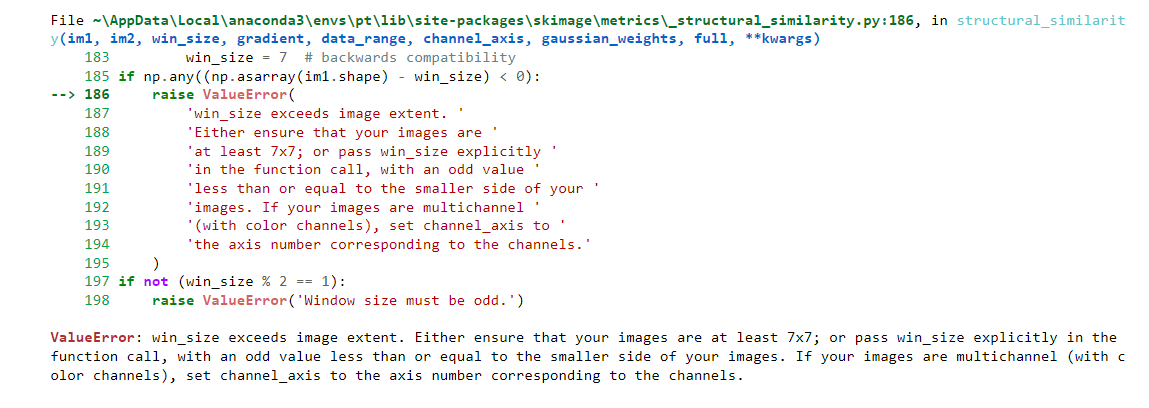

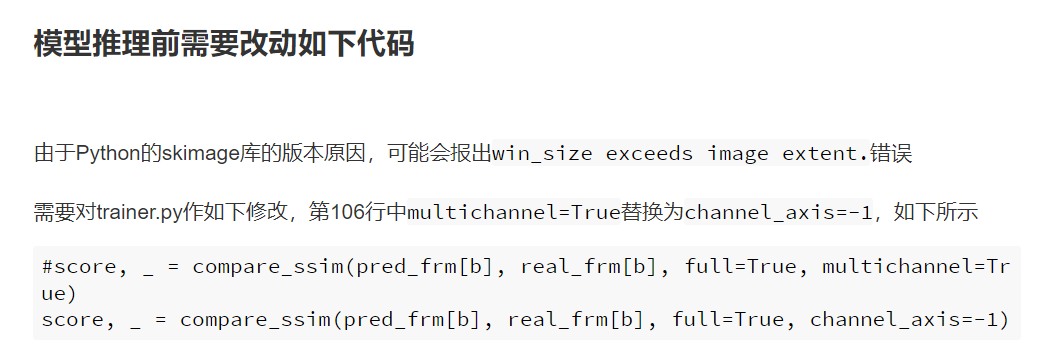

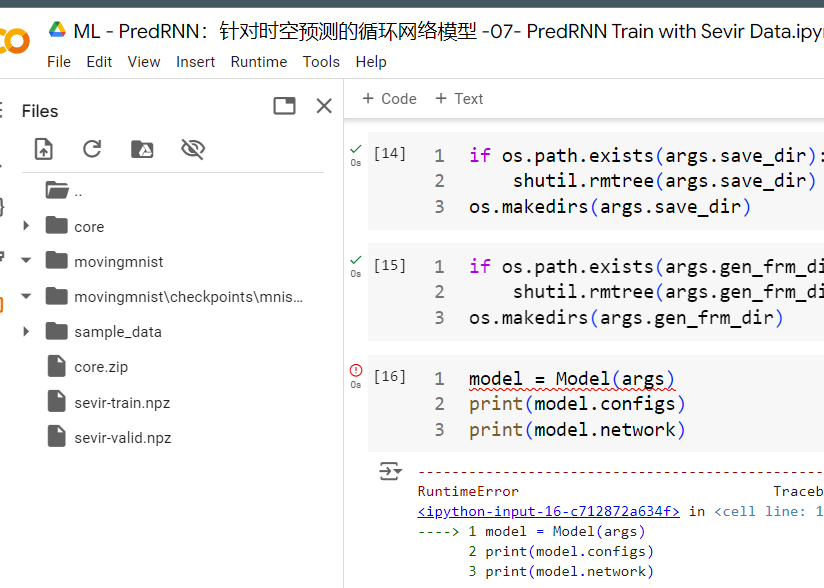